In [1]:
# from IPython.core.display import clear_output
# # install qiskit
# %pip install qiskit
# clear_output()

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

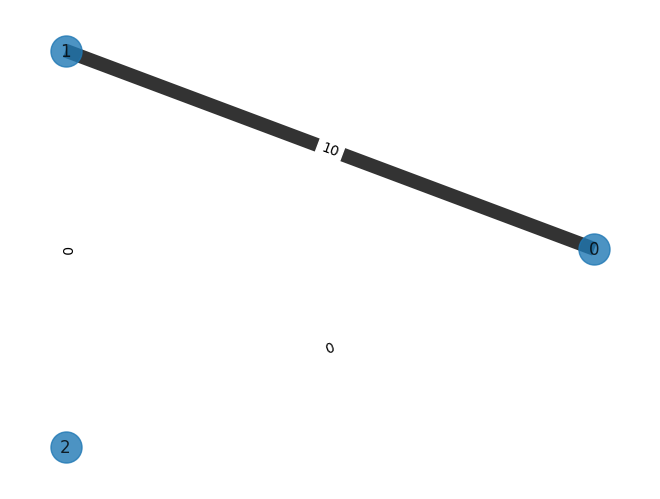

In [3]:
n_nodes = 3
# 设定深度和随机种子
depth = 200
np.random.seed(0)

G = nx.Graph()
G.add_nodes_from(range(n_nodes))
# edges = [(i, (i + 1) % n_nodes, 1) for i in range(n_nodes)]
# edges = [(i, (i + 1) % n_nodes, (i + 1) % 3*100+1) for i in range(n_nodes)]
edges = [(i, (i + 1) % n_nodes, 10 if i == 0 else 0) for i in range(n_nodes)]
G.add_weighted_edges_from(edges)

pos = nx.circular_layout(G)

nx.draw(G, pos, width=[data['weight'] for u, v, data in G.edges(data=True)], with_labels=True, alpha=0.8, node_size=500)

edge_labels = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [4]:
def shared_edges(x, Gr):
    """
    根据输入的二进制字符串 x，判断图 Gr 的最大切割问题中被 shared 的边数。

    Parameters:
    - x: str
        二进制字符串，表示图 Gr 的一个切割。
    - Gr: networkx.Graph
        输入的图。

    Returns:
    - int
        共享的边数。
    """
    num_shared_edges = 0

    for edge in Gr.edges():
        if x[edge[0]] != x[edge[1]]:
            # 如果两个节点在不同的切割中，边就是共享的
            num_shared_edges += 1

    return num_shared_edges

In [5]:
def build_qaoa_circ(G, theta):
  """
  Creates a QAOA circuit parametrized by theta

  Args:
    G: networkx graph
    theta: list
           parameters for the unitary operators
  
  Returns:
    qc: qiskit circuit
  """
  nqubits = len(G.nodes())
  b_depth = depth # number of "layers" of alternating unitaries
  qc = QuantumCircuit(nqubits)
  beta = theta[:(b_depth + 1) * n_nodes]
  gamma = theta[(b_depth + 1) * n_nodes:]

  # initialize the circuit with Hadamard gates
  for i in range(nqubits):
    qc.h(i)

  # add unitary layers
  for j in range(b_depth):
    
    # problem unitary
    for pair in list(G.edges()):
      # print(pair)
      # qc.rzz(2 * gamma[j], pair[0], pair[1])
      k = pair[0]
      l = pair[1]
      qc.cnot(k, l)
      qc.rz(gamma[j * len(pair) + k], l)
      qc.cnot(k, l)
      # qc.cp(-2*gamma[j], k, l)
      # qc.p(gamma[j], k)
      # qc.p(gamma[j], l)
      qc.barrier()
    # mixing unitary
    for i in range(nqubits):
      # print("2====", j * nqubits + i)
      qc.rx(beta[j * nqubits + i], i)
      # qc.barrier()
  # measurement
  qc.measure_all()

  return qc


In [6]:
def cost_function(x, G):
  """
  Given a bitstring x  representing a bipartite, this function returns the number of edges shared between the two partitions of the graph.

  Args:
    x: str
      bitstring representing a birpartite of the graph
    G: networkx graph

  Returns:
    C: float
       cost function of a given partition
  """
  C = 0
  E = G.edges()
  num = [int(char) for char in x]
  for pair in E:
    i = pair[0]
    j = pair[1]
    w = G[i][j]['weight']
    C = C + w * (num[i]*(1-num[j])+num[j]*(1-num[i]))
            
  return C

def compute_expectation(counts, G):
  """
  Computes expectation value based on measurement results
    
  Args:
    counts: dict
            key as bitstring, val as count
           
    G: networkx graph
        
  Returns:
    EV: float
        expectation value
  """
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x, G)
    EV -= C*count
    total_count += count

  return EV/total_count

def expectation_from_sample(G, shots = 2000):
  """
  Runs the QAOA circuit.

  Args:
    G: networkx graph
    depth: int
           number of "layer"s of unitaries
  """
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
        
    qc = build_qaoa_circ(G, theta)
    counts = backend.run(qc, seed_simulator=10, 
                            shots=shots).result().get_counts()
        
    # print(qc.draw(scale=0.2, fold=30))
    return compute_expectation(counts, G)
    
  return execute_circ

### Minimizing the Cost Function

In [7]:
from scipy.optimize import minimize
import numpy as np

expectation = expectation_from_sample(G)
# 定义你的期望值函数 expectation_from_sample(G)

def callback(x):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        print(f"Iteration {iteration_count}, Result: {expectation(x)}")

# 随机初始化参数
params = np.random.rand(depth * n_nodes * 2)

# 设定最大迭代次数
max_iterations = 600

# 初始化迭代计数器
iteration_count = 0

# 使用 COBYLA 方法进行最小化，并设置 callback 函数
res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)

# 输出最终结果
print("Final Result:", res)


Iteration 10, Result: -2.31
Iteration 20, Result: -4.64
Iteration 30, Result: -4.435
Iteration 40, Result: -4.88
Iteration 50, Result: -5.545
Iteration 60, Result: -8.555
Iteration 70, Result: -8.335
Iteration 80, Result: -8.96
Iteration 90, Result: -8.96
Iteration 100, Result: -7.875
Iteration 110, Result: -7.975
Iteration 120, Result: -8.59
Iteration 130, Result: -9.14
Iteration 140, Result: -8.36
Iteration 150, Result: -8.245
Iteration 160, Result: -8.315
Iteration 170, Result: -7.945
Iteration 180, Result: -8.605
Iteration 190, Result: -7.345
Iteration 200, Result: -9.59
Iteration 210, Result: -8.25
Iteration 220, Result: -9.43
Iteration 230, Result: -8.59
Iteration 240, Result: -8.55
Iteration 250, Result: -9.05
Iteration 260, Result: -7.285
Iteration 270, Result: -9.72
Iteration 280, Result: -8.74
Iteration 290, Result: -8.785
Iteration 300, Result: -8.105
Iteration 310, Result: -8.735
Iteration 320, Result: -8.415
Iteration 330, Result: -8.92
Iteration 340, Result: -7.82
Iterati

### Check the Result

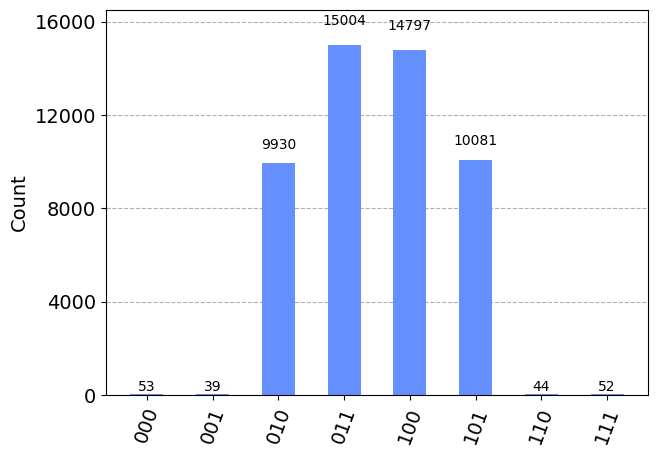

In [8]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000

qc_res = build_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10, shots = 50000).result().get_counts()
plot_histogram(counts)


In [9]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
for x in sorted_counts[:20]:
  print(x, counts[x], cost_function(x, G))
# qc_res.draw(output='mpl', scale=1, fold=30)

011 15004 10
100 14797 10
101 10081 10
010 9930 10
000 53 0
111 52 0
110 44 0
001 39 0
